In [11]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import seaborn as sns
import torch.nn.functional as F
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# for lstm+resnet
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import cv2
import os
import numpy as np
from tqdm import tqdm

# Paths to real and fake video folders
DATASET_PATH = "/content/drive/MyDrive/celeb"
REAL_FOLDERS = ["Celeb-real","YouTube-real"]
FAKE_FOLDER = "Celeb-synthesis"

# Define data augmentation and preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # ResNet expects 3-channel normalization
])

# Function to extract frames from a video
def extract_frames(video_path, frame_count=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < frame_count:
        cap.release()
        return None  # Skip videos with too few frames

    # Compute evenly spaced frame indices but in sequential order
    step = max(total_frames // frame_count, 1)
    frame_indices = [i * step for i in range(frame_count)]  # Sequential selection

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = transform(frame)  # Shape: [C, H, W]
        frames.append(frame)

    cap.release()

    if len(frames) == frame_count:
        return torch.stack(frames)  # Shape: [T, C, H, W]
    return None


# Custom Dataset Class
class DeepfakeDataset(Dataset):
    def __init__(self, dataset_path, real_folders, fake_folder, frame_count=10, max_fake_videos=900):
        self.videos = []
        self.labels = []

        # Load real videos
        for folder in real_folders:
            folder_path = os.path.join(dataset_path, folder)
            self.videos.extend([(os.path.join(folder_path, f), 0) for f in os.listdir(folder_path)])

        # Load fake videos
        fake_folder_path = os.path.join(dataset_path, fake_folder)
        fake_videos = [(os.path.join(fake_folder_path, f), 1) for f in os.listdir(fake_folder_path)][:max_fake_videos]
        self.videos.extend(fake_videos)

        self.frame_count = frame_count
        self.data = []
        self.labels = []

        print("Processing videos...")
        for video_path, label in tqdm(self.videos):
            frames = extract_frames(video_path, self.frame_count)
            if frames is not None:
                self.data.append(frames)  # Shape: [T, C, H, W]
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frames = self.data[idx]  # Shape: [T, C, H, W]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return frames, label  # Frames will be fed to ResNet, then to LSTM

# Initialize dataset
dataset = DeepfakeDataset(DATASET_PATH, REAL_FOLDERS, FAKE_FOLDER, frame_count=10, max_fake_videos=900)

# Save dataset to Google Drive
torch.save(dataset.data, '/content/drive/MyDrive/extracted_frames_celeb_lstm.pt')
torch.save(dataset.labels, '/content/drive/MyDrive/extracted_labels_celeb_lstm.pt')

print("✅ Frame extraction complete! Dataset saved to Google Drive.")


Processing videos...


100%|██████████| 1790/1790 [15:28<00:00,  1.93it/s]


✅ Frame extraction complete! Dataset saved to Google Drive.


In [ ]:
torch.save(dataset.data, '/content/drive/MyDrive/extracted_frames_celeb.pt', _use_new_zipfile_serialization=True)


In [5]:
#resnet dataloader

import torch
from torch.utils.data import DataLoader, Dataset, random_split

# Paths to pre-extracted frame tensors
frames_path = "/content/drive/MyDrive/extracted_frames_celeb_lstm.pt"
labels_path = "/content/drive/MyDrive/extracted_labels_celeb_lstm.pt"

class DeepfakeDataset(Dataset):
    def __init__(self, frames_path, labels_path):
        self.data = torch.load(frames_path)
        self.labels = torch.load(labels_path)

        if len(self.data) != len(self.labels):
            raise ValueError("Mismatch: Frames and labels have different lengths!")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frames = self.data[idx].float()  # Shape: [T, C, H, W]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return frames, label  # Returned format: ([T, C, H, W], label)

# Load dataset
dataset = DeepfakeDataset(frames_path, labels_path)

# Split dataset
train_size = int(0.75 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader with correct batch format
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Checking Real vs Fake Distribution
def count_real_fake(dataset, original_labels):
    real = sum(1 for i in dataset.indices if original_labels[i] == 0)
    fake = sum(1 for i in dataset.indices if original_labels[i] == 1)
    return real, fake

train_real, train_fake = count_real_fake(train_dataset, dataset.labels)
val_real, val_fake = count_real_fake(val_dataset, dataset.labels)
test_real, test_fake = count_real_fake(test_dataset, dataset.labels)

print(f"Train Set - Real: {train_real}, Fake: {train_fake}")
print(f"Validation Set - Real: {val_real}, Fake: {val_fake}")
print(f"Test Set - Real: {test_real}, Fake: {test_fake}")


<ipython-input-5-239f5ef14963>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(frames_path)
<ipython-input-5-239f5ef14963>:13: FutureWarning: You ar

Train Set - Real: 436, Fake: 455
Validation Set - Real: 97, Fake: 81
Test Set - Real: 56, Fake: 64


In [6]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights

class DeepfakeDetector(nn.Module):
    def __init__(self, hidden_dim=256, num_layers=2, num_classes=2, dropout=0.5):
        super(DeepfakeDetector, self).__init__()

        # Load Pretrained ResNet with Correct Weights
        resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer

        # Freeze Early Layers for Better Transfer Learning
        for param in list(self.resnet.children())[:6]:
            for p in param.parameters():
                p.requires_grad = False

        # LSTM for Temporal Processing
        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=dropout)

        self.final_dropout = nn.Dropout(p=dropout)  # Dropout only in training mode

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape  # (Batch, Time, Channels, Height, Width)

        # Flatten batch & time
        x = x.view(B * T, C, H, W)

        # Feature Extraction via ResNet
        x = self.resnet(x)  # Output: (B*T, 512, 1, 1)
        x = x.view(B, T, 512)  # Reshape for LSTM

        # LSTM Processing
        lstm_out, _ = self.lstm(x)

        # Apply Dropout Only in Training Mode
        if self.training:
            lstm_out = self.final_dropout(lstm_out)

        # Use Mean Pooling Instead of Last Frame
        lstm_out = torch.mean(lstm_out, dim=1)

        # Classification
        output = self.fc(lstm_out)
        return output


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]
100%|██████████| 12/12 [00:00<00:00, 16.74it/s]


Epoch 1/10, Train Loss: 0.6871, Train Accuracy: 55.44%, Val Loss: 0.6783, Val Accuracy: 61.24%
Model saved at Epoch 1 with Validation Loss: 0.6783


100%|██████████| 12/12 [00:00<00:00, 18.83it/s]


Epoch 2/10, Train Loss: 0.6594, Train Accuracy: 71.72%, Val Loss: 0.6401, Val Accuracy: 78.09%
Model saved at Epoch 2 with Validation Loss: 0.6401


100%|██████████| 12/12 [00:00<00:00, 19.61it/s]


Epoch 3/10, Train Loss: 0.5961, Train Accuracy: 80.13%, Val Loss: 0.5587, Val Accuracy: 82.02%
Model saved at Epoch 3 with Validation Loss: 0.5587


100%|██████████| 12/12 [00:00<00:00, 19.59it/s]


Epoch 4/10, Train Loss: 0.4926, Train Accuracy: 83.50%, Val Loss: 0.4585, Val Accuracy: 83.71%
Model saved at Epoch 4 with Validation Loss: 0.4585


100%|██████████| 12/12 [00:00<00:00, 19.43it/s]


Epoch 5/10, Train Loss: 0.3857, Train Accuracy: 86.87%, Val Loss: 0.3933, Val Accuracy: 84.83%
Model saved at Epoch 5 with Validation Loss: 0.3933


100%|██████████| 12/12 [00:00<00:00, 19.53it/s]


Epoch 6/10, Train Loss: 0.2962, Train Accuracy: 90.68%, Val Loss: 0.3695, Val Accuracy: 84.83%
Model saved at Epoch 6 with Validation Loss: 0.3695


100%|██████████| 12/12 [00:00<00:00, 19.43it/s]


Epoch 7/10, Train Loss: 0.2376, Train Accuracy: 92.03%, Val Loss: 0.3802, Val Accuracy: 87.08%


100%|██████████| 12/12 [00:00<00:00, 14.62it/s]


Epoch 8/10, Train Loss: 0.1974, Train Accuracy: 93.27%, Val Loss: 0.3930, Val Accuracy: 87.64%


100%|██████████| 12/12 [00:00<00:00, 18.89it/s]


Epoch 9/10, Train Loss: 0.1634, Train Accuracy: 93.71%, Val Loss: 0.4005, Val Accuracy: 89.33%


100%|██████████| 12/12 [00:00<00:00, 19.36it/s]


Epoch 10/10, Train Loss: 0.1232, Train Accuracy: 95.06%, Val Loss: 0.4357, Val Accuracy: 87.64%


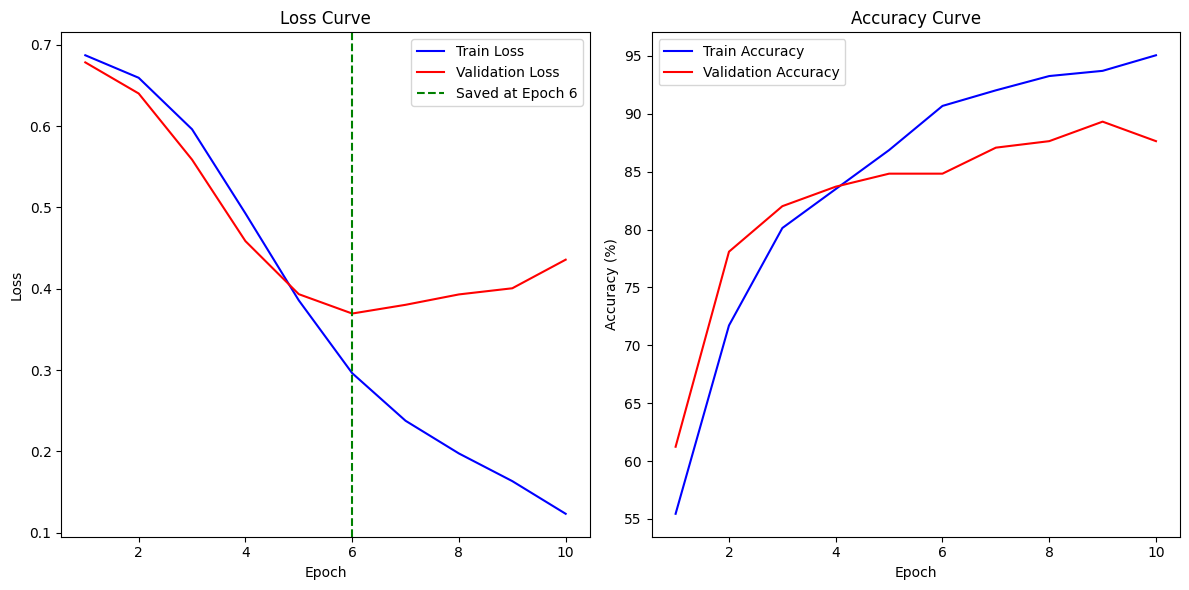

In [7]:
#resnet training loop

# Define the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, and optimizer
model = DeepfakeDetector().to(device)  # ResNet + LSTM model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 10

# Lists to store loss and accuracy
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

best_val_loss = float('inf')  # Track the lowest validation loss

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_train_preds, all_train_labels = [], []

    for frames, labels in tqdm(train_loader):
        frames, labels = frames.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)  # Forward pass through ResNet + LSTM
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Collect predictions and labels for accuracy calculation
        _, predicted = torch.max(outputs, 1)
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

        running_loss += loss.item()

    # Compute training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    all_val_preds, all_val_labels = [], []

    with torch.no_grad():
        for frames, labels in tqdm(val_loader):
            frames, labels = frames.to(device), labels.to(device)
            outputs = model(frames)
            loss = criterion(outputs, labels)

            # Collect predictions and labels for accuracy calculation
            _, predicted = torch.max(outputs, 1)
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

            running_val_loss += loss.item()

    # Compute validation loss and accuracy
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds) * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # **Save the model if this epoch has the lowest validation loss**
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }
        torch.save(checkpoint, "resnet_lstm_model_version_4.pth")
        saved_epoch = epoch
        print(f"Model saved at Epoch {epoch+1} with Validation Loss: {best_val_loss:.4f}")

# Function to plot learning curves
def plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies, saved_epoch):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Plot the loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')

    if saved_epoch != -1:
        plt.axvline(x=saved_epoch+1, color='green', linestyle='--', label=f'Saved at Epoch {saved_epoch+1}')

    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot the accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')

    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the learning curves
plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies, saved_epoch)


In [8]:
# resnet

# Initialize the model (Must match saved architecture)
model = DeepfakeDetector().to(device)  # ResNet + LSTM model

# Load the best model checkpoint
checkpoint = torch.load("resnet_lstm_model_version_4.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"ResNet-LSTM Model loaded from checkpoint at Epoch {checkpoint['epoch'] + 1}")


ResNet-LSTM Model loaded from checkpoint at Epoch 6


<ipython-input-8-b40d5458970b>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("resnet_lstm_model_version_4.pth", map_location=device)


In [9]:
import os

old_name = "resnet_lstm_model_version_4.pth"
new_name = "deepfake_detector_v5.pth"

os.rename(old_name, new_name)


In [12]:
# resnet evaluation

# Function to evaluate model performance
def evaluate(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for frames, labels in dataloader:
            frames, labels = frames.to(device), labels.to(device)

            # Forward pass through ResNet + LSTM model
            outputs = model(frames)

            # Apply softmax to get class probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)  # Get predicted labels

            # Store results for evaluation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class '1' (Fake)

    # Convert lists to NumPy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average='binary')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    return accuracy, f1, conf_matrix, fpr, tpr, thresholds, roc_auc, all_labels, all_probs

# Load best model checkpoint
checkpoint = torch.load("deepfake_detector_v5.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f" ResNet-LSTM Model loaded from Epoch {checkpoint['epoch'] + 1}")

# Run evaluation on test dataset
test_acc, test_f1, test_conf_matrix, fpr, tpr, thresholds, roc_auc, all_labels, all_probs = evaluate(model, test_loader, device)

# Print results
print(f" Test Accuracy: {test_acc:.2f}%")
print(f" Test F1 Score: {test_f1:.2f}")
print(f" Confusion Matrix:\n{test_conf_matrix}")
print(f" ROC AUC: {roc_auc:.2f}")


<ipython-input-12-c694cbdb0255>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("deepfake_detector_v5.pth", map_location=device)


 ResNet-LSTM Model loaded from Epoch 6
 Test Accuracy: 95.83%
 Test F1 Score: 0.96
 Confusion Matrix:
[[53  3]
 [ 2 62]]
 ROC AUC: 0.96


<Figure size 640x480 with 0 Axes>

<ipython-input-14-86c19152a2ce>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("deepfake_detector_v5.pth", map_location=device)


 ResNet-LSTM Model loaded from Epoch 6


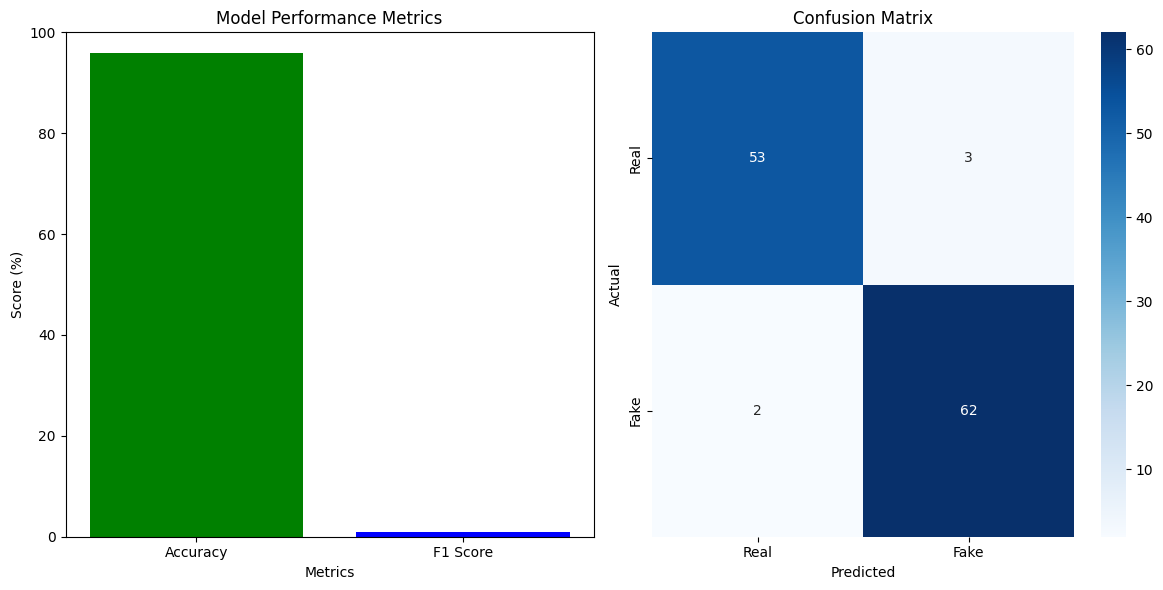

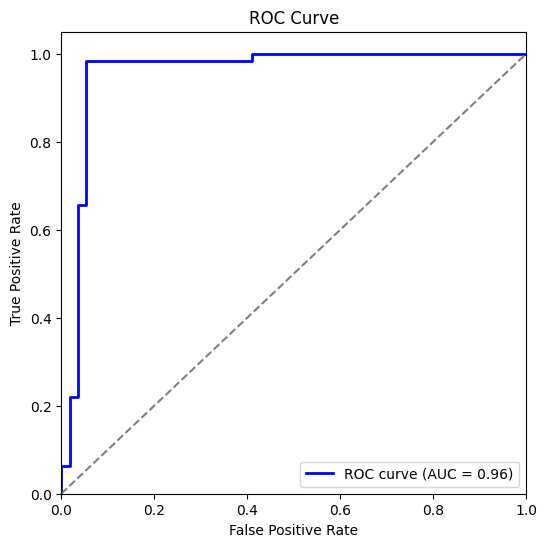

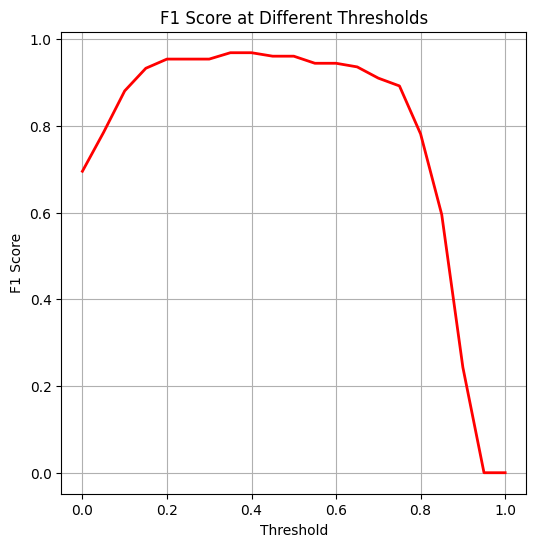

In [14]:
# resnet visualization
from sklearn.metrics import f1_score as sklearn_f1_score  # Avoiding name conflicts

# Function to plot evaluation metrics for ResNet + LSTM
def plot_evaluation_metrics(accuracy, f1_score, conf_matrix, fpr, tpr, thresholds, roc_auc, all_labels, all_probs):
    plt.figure(figsize=(12, 6))

    # Bar Plot for Accuracy and F1 Score
    plt.subplot(1, 2, 1)
    plt.bar(["Accuracy", "F1 Score"], [accuracy, f1_score], color=["green", "blue"])
    plt.ylim(0, 100)
    plt.xlabel("Metrics")
    plt.ylabel("Score (%)")
    plt.title("Model Performance Metrics")

    # Confusion Matrix Plot
    plt.subplot(1, 2, 2)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

    # Plot ROC Curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle="--")  # Diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Compute F1 Score for different thresholds
    threshold_range = np.arange(0.0, 1.05, 0.05)
    f1_scores = [sklearn_f1_score(all_labels, (all_probs >= threshold).astype(int), average="binary") for threshold in threshold_range]

    # Plot F1 Score vs Threshold
    plt.figure(figsize=(6, 6))
    plt.plot(threshold_range, f1_scores, color="red", lw=2)
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title("F1 Score at Different Thresholds")
    plt.grid(True)
    plt.show()

plt.tight_layout()
plt.show()


# Load best ResNet + LSTM checkpoint
checkpoint = torch.load("deepfake_detector_v5.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f" ResNet-LSTM Model loaded from Epoch {checkpoint['epoch'] + 1}")

# Run evaluation on test dataset
test_acc, test_f1, test_conf_matrix, fpr, tpr, thresholds, roc_auc, all_labels, all_probs = evaluate(model, test_loader, device)

# Plot the evaluation results
plot_evaluation_metrics(test_acc, test_f1, test_conf_matrix, fpr, tpr, thresholds, roc_auc, all_labels, all_probs)


In [15]:
import shutil

# Define the path to save the model in Google Drive
model_path = "/content/drive/My Drive/resnet_lstm_model_version_4.pth"

# Copy model from Colab storage to Google Drive
shutil.copy("deepfake_detector_v5.pth", model_path)

print(f" Model saved in Google Drive: {model_path}")


 Model saved in Google Drive: /content/drive/My Drive/resnet_lstm_model_version_4.pth
